In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *

from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Grid scale climate-fire data

### Set up pandas dataframe with data until March 2023

In [1]:
clim_df= init_clim_fire_grid(res= '12km', tscale= 'monthly', start_year= 1952, final_year= 2023, seas_pred_flag= True, pred_mon_ind= 3) #pred_mon_ind --> index of most recent month in calendar year
# clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')

### Include oceanic indices: MJO, Nino3.4, MEI

In [46]:
# create a xarray time series object name 'oi_time_series' for all months between 1 Jan 1952 and 1 Mar 2023
oi_time_series = pd.date_range(start='1952-01-01', end='2023-03-01', freq='MS')
oi_time_series = xarray.DataArray(oi_time_series, dims=('time'), coords={'time': oi_time_series})

In [47]:
# create a xarray time series object for all days between 1 Jun 1974 and 5 May 2023
mjo_time_series = pd.date_range(start='1974-06-01', end='2023-05-05', freq='D')
mjo_time_series = xarray.DataArray(mjo_time_series, dims=('time'), coords={'time': mjo_time_series})

rmm1_xarr= xarray.open_dataset('../data/oi_data/mjo_may23.nc')['RMM1']
rmm2_xarr= xarray.open_dataset('../data/oi_data/mjo_may23.nc')['RMM2']

rmm1_xarr= rmm1_xarr.assign_coords(T= mjo_time_series.time.values)
rmm2_xarr= rmm2_xarr.assign_coords(T= mjo_time_series.time.values)

# coarsen rmm1_xarr and rmm2_xarr to monthly resolution
rmm1_xarr= rmm1_xarr.resample(T= '1MS').mean()
rmm2_xarr= rmm2_xarr.resample(T= '1MS').mean()

# expand rmm1_xarr, rmm2_xarr with NaNs to match the length of oi_time_series
rmm1_xarr= rmm1_xarr.reindex(T= oi_time_series.time.values)
rmm2_xarr= rmm2_xarr.reindex(T= oi_time_series.time.values)

In [48]:
# create a xarray time series object named 'nino_time_series' for all months between 15 Jan 1950 and 15 Apr 2023
nino_time_series = pd.date_range(start='1950-01-01', end='2023-04-01', freq='MS')
nino_time_series = xarray.DataArray(nino_time_series, dims=('time'), coords={'time': nino_time_series})

nino34_xarr= xarray.open_dataset('../data/oi_data/nino34_apr23.nc', decode_times= False)['NINO34']
nino34_xarr= xarray.DataArray(nino34_xarr.values.flatten(), dims=('time'), coords={'time': nino_time_series.time.values})

In [49]:
# read in data from '../data/OI_data/mei_mar23.txt' with columns: year, jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
mei_df= pd.read_csv('../data/oi_data/mei_mar23.txt', sep= '\s+', header= None, names= ['year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], skiprows= 1)
mei_df= mei_df.melt(id_vars= ['year'], var_name= 'month', value_name= 'mei')

# convert mei_df to xarray DataArray with time starting from 1 Jan 1950 to 1 Dec 2023
mei_df['time']= pd.to_datetime(mei_df['year'].astype(str) + '-' + mei_df['month'].astype(str))
mei_df= mei_df.drop(columns= ['year', 'month'])
mei_df= mei_df.set_index('time')
mei_df= mei_df.sort_index() # sort mei_df by time
mei_xarr= xarray.DataArray(mei_df['mei'].values, dims=('time'), coords={'time': mei_df.index.values})

# expand mei_xarr with NaNs to match the length of oi_time_series
mei_xarr= mei_xarr.reindex(time= oi_time_series.time.values)

In [65]:
# create a pandas Series for all oi_xarr such that each element is repeated 32240 times (i.e. the number of grid cells in the 12km grid)

mei_series= pd.Series(np.nan_to_num(mei_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
nino34_series= pd.Series(np.nan_to_num(nino34_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
rmm1_series= pd.Series(np.nan_to_num(rmm1_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
rmm2_series= pd.Series(np.nan_to_num(rmm2_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)

# add mei_series, nino34_series, rmm1_series, rmm2_series to clim_df
clim_df['mei']= mei_series
clim_df['nino34']= nino34_series
clim_df['rmm1']= rmm1_series
clim_df['rmm2']= rmm2_series

In [68]:
clim_df.to_hdf('../data/clim_12km_1952_2023_data.h5', key= 'df', mode= 'w')

## Subseasonal and S2S forecasts with NGBoost

In [2]:
clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')

# Group clim_df by X and Y to get a list of all non-nan grid cells

clim_df_groups= clim_df.dropna().groupby(['X', 'Y'], as_index= False)
clim_df_group_keys= clim_df_groups.groups.keys()

In [3]:
target_arr= np.append(np.append(np.arange(5, 855, 12), np.arange(5, 855, 12)+1), np.arange(5, 855, 12)+2)
lead1mons_pred_arr= target_arr - 1
lead2mons_pred_arr= target_arr - 2
lead3mons_pred_arr= target_arr - 3

lead1mons_pred_df= clim_df[clim_df['time'].isin(lead1mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])
lead2mons_pred_df= clim_df[clim_df['time'].isin(lead2mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])
lead3mons_pred_df= clim_df[clim_df['time'].isin(lead3mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])

tmax_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Tmax'].reset_index().drop(columns= ['index']).rename(columns= {'Tmax': 'Tmax_target'})
prec_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Prec'].reset_index().drop(columns= ['index']).rename(columns= {'Prec': 'Prec_target'})
vpd_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['VPD'].reset_index().drop(columns= ['index']).rename(columns= {'VPD': 'VPD_target'})
sm_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['SM_0_100cm'].reset_index().drop(columns= ['index']).rename(columns= {'SM_0_100cm': 'SM_target'})
ffwi_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['FFWI_max7'].reset_index().drop(columns= ['index']).rename(columns= {'FFWI_max7': 'FFWI_target'})

lead1mons_df= pd.concat([lead1mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, sm_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
lead2mons_df= pd.concat([lead2mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, sm_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
lead3mons_df= pd.concat([lead3mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, sm_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)

In [4]:
pred_arr_all= {'Tmax': ['Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI' , 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'Prec': ['Prec', 'Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'VPD': ['VPD', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'SM': ['SM_0_100cm', 'Tmax', 'Prec', 'Solar', 'RH', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2']}
pred_arr_dynamic= {'Tmax': ['Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'Prec': ['Prec', 'Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], \
                   'VPD': ['VPD', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], \
                    'SM': ['SM_0_100cm', 'Tmax', 'Prec', 'Solar', 'RH', 'PDSI']} 

### NGBoost training

In [21]:
pred_var_arr= ['FFWI']
run_id= '05_30_23'

for pred_var in tqdm(pred_var_arr):
    X= lead2mons_df[pred_arr_all[pred_var]][lead2mons_df.time < 700] # train+val:test :: 80:20
    #X_scaled= X - X.mean(axis= 0, skipna= True)/X.std(axis= 0, skipna= True)
    X_scaled= pd.concat([(X[pred_arr_dynamic[pred_var]] - X[pred_arr_dynamic[pred_var]].mean(axis= 0, skipna= True))/X[pred_arr_dynamic[pred_var]].std(axis= 0, skipna= True), \
                                            X[['Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
    Y= lead2mons_df.iloc[X_scaled.index][pred_var + '_target']
    Y_scaled= (Y - Y.mean())/Y.std()
    X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2)

    poly = PolynomialFeatures(1)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)

    ngb = NGBRegressor(minibatch_frac= 0.1, random_state= 42).fit(X_train_poly, Y_train)
    Y_preds = ngb.predict(X_val_poly)
    Y_dists = ngb.pred_dist(X_val_poly)

    # test Mean Squared Error
    test_MSE = mean_squared_error(Y_preds, Y_val)
    print('Test MSE', test_MSE)

    # test Negative Log Likelihood
    test_NLL = -Y_dists.logpdf(Y_val).mean()
    print('Test NLL', test_NLL)

    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id +'_mb_%.2f.p'%(0.1)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("wb") as f:
        pickle.dump(ngb, f)

  0%|          | 0/1 [00:00<?, ?it/s]

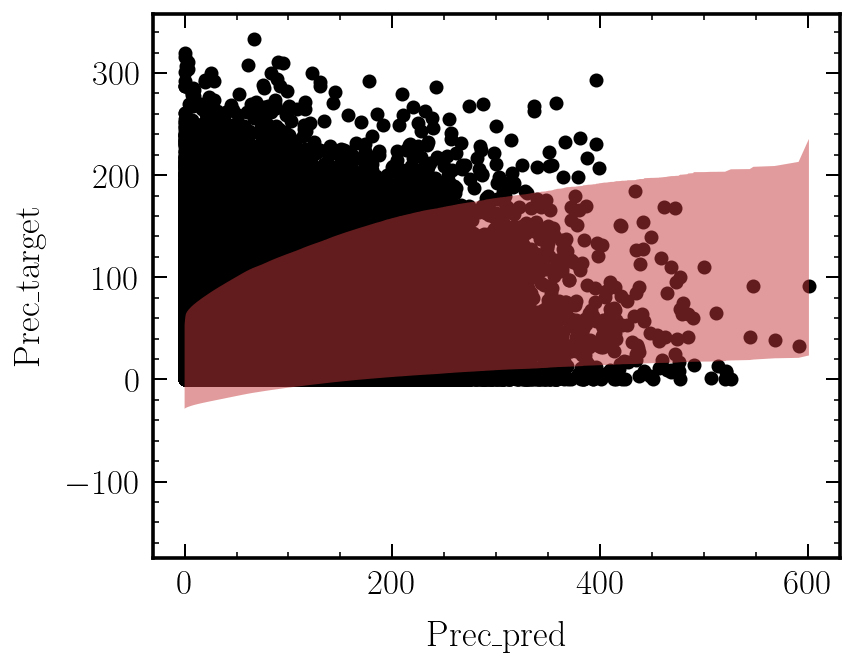

In [8]:
plt.scatter(X_val_poly[:, 1]*X[pred_var].std(axis= 0, skipna= True) + X[pred_var].mean(axis= 0, skipna= True), Y_val*Y.std() + Y.mean(), color= 'black')

Y_pred_low_1sig= (Y_dists.params['loc'] - 1.96 * Y_dists.params['scale'])*Y.std() + Y.mean()
Y_pred_high_1sig= (Y_dists.params['loc'] + 1.96 * Y_dists.params['scale'])*Y.std() + Y.mean()
plt.fill_between(np.sort(X_val_poly[:, 1]*X[pred_var].std(axis= 0, skipna= True) + X[pred_var].mean(axis= 0, skipna= True)), np.sort(Y_pred_low_1sig), \
                                                np.sort(Y_pred_high_1sig), alpha= 0.5)
plt.xlabel(r'%s_pred'%pred_var, fontsize= 18)
plt.ylabel(r'%s_target'%pred_var, fontsize= 18)
plt.show()

### NGBoost predictions 

In [9]:
pred_var= 'Prec'
run_id= '05_30_23'
mb_frac= 0.1

ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
with file_path.open("rb") as f:
    ngb= pickle.load(f)

In [10]:
pred_list= deepcopy(pred_arr_all[pred_var])
pred_list.extend(['time', 'X', 'Y'])
tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc')
ind_nan= clim_df.groupby('time').get_group(0).dropna().index
len_xcoord= len(tmax_xr.X)
len_ycoord= len(tmax_xr.Y)

X= lead2mons_df[pred_list][lead2mons_df.time < 700]
Y= lead2mons_df.iloc[X.index][pred_var + '_target'] # ensure that Y is always the target variable and not a predictor

In [11]:
Y_dist_loc= []
Y_dist_scale= []
Y_obs= []

lead2mons_groups= lead2mons_df.groupby(['time'], as_index= False)
for m in tqdm(lead2mons_pred_arr):
    X_test= lead2mons_groups.get_group(m)[pred_list]
    #X_test_scaled= X_test - X.mean(axis= 0, skipna= True)/X.std(axis= 0, skipna= True)
    X_test_scaled= pd.concat([(X_test[pred_arr_dynamic[pred_var]] - X[pred_arr_dynamic[pred_var]].mean(axis= 0, skipna= True))/X[pred_arr_dynamic[pred_var]].std(axis= 0, skipna= True), \
                                            X_test[['Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
    poly = PolynomialFeatures(1)
    X_test_poly= poly.fit_transform(X_test_scaled)
    
    tmplocarr= np.ones(len_xcoord*len_ycoord)*np.nan
    tmpsigarr= np.ones(len_xcoord*len_ycoord)*np.nan
    tmpobsarr= np.ones(len_xcoord*len_ycoord)*np.nan
    tmplocarr[ind_nan]= ngb.pred_dist(X_test_poly).params['loc']*Y.std() + Y.mean()
    tmpsigarr[ind_nan]= ngb.pred_dist(X_test_poly).params['scale']*Y.std()
    tmpobsarr[ind_nan]= lead2mons_groups.get_group(m)[pred_var + '_target']

    Y_dist_loc.append(tmplocarr)
    Y_dist_scale.append(tmpsigarr)
    Y_obs.append(tmpobsarr)

100%|██████████| 213/213 [05:28<00:00,  1.54s/it]


In [13]:
# convert Y_dist_loc and Y_dist_scale to xarray with X and Y dimensions equal to len_ycoord and len_xcoord

Y_dist_loc_xr= xarray.DataArray(np.array(Y_dist_loc).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                        coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
Y_dist_scale_xr= xarray.DataArray(np.array(Y_dist_scale).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                        coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
Y_obs_xr= xarray.DataArray(np.array(Y_obs).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                        coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])

Y_dist_loc_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
Y_dist_scale_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
Y_obs_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_lead2mo_obs.nc')

### NGBoost plotting 

In [14]:
pred_var= 'Prec'
unit_arr= {'Tmax': 'degC', 'Prec': 'mm' ,'VPD': 'hPa', 'FFWI': 'Intensity', 'SM': 'unitless'}
mb_frac= 0.1

Y_dist_loc_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
Y_dist_scale_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
Y_obs_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_lead2mo_obs.nc')

In [15]:
grid_all= np.where(~np.isnan(Y_dist_loc_xr[0, :, :])) # choose random non nan grid cell for plotting
pearson_r_arr= [stats.pearsonr(Y_dist_loc_xr[:, grid_all[0][g], grid_all[1][g]], Y_obs_xr[:, grid_all[0][g], grid_all[1][g]])[0] for g in tqdm(range(len(grid_all[0])))]

best_ind_arr= np.argsort(pearson_r_arr)[-3:]
worst_ind_arr= np.argsort(pearson_r_arr)[:3]
rand_ind_arr= np.random.randint(0, len(grid_all[0]), 3)

100%|██████████| 23903/23903 [01:18<00:00, 304.20it/s]


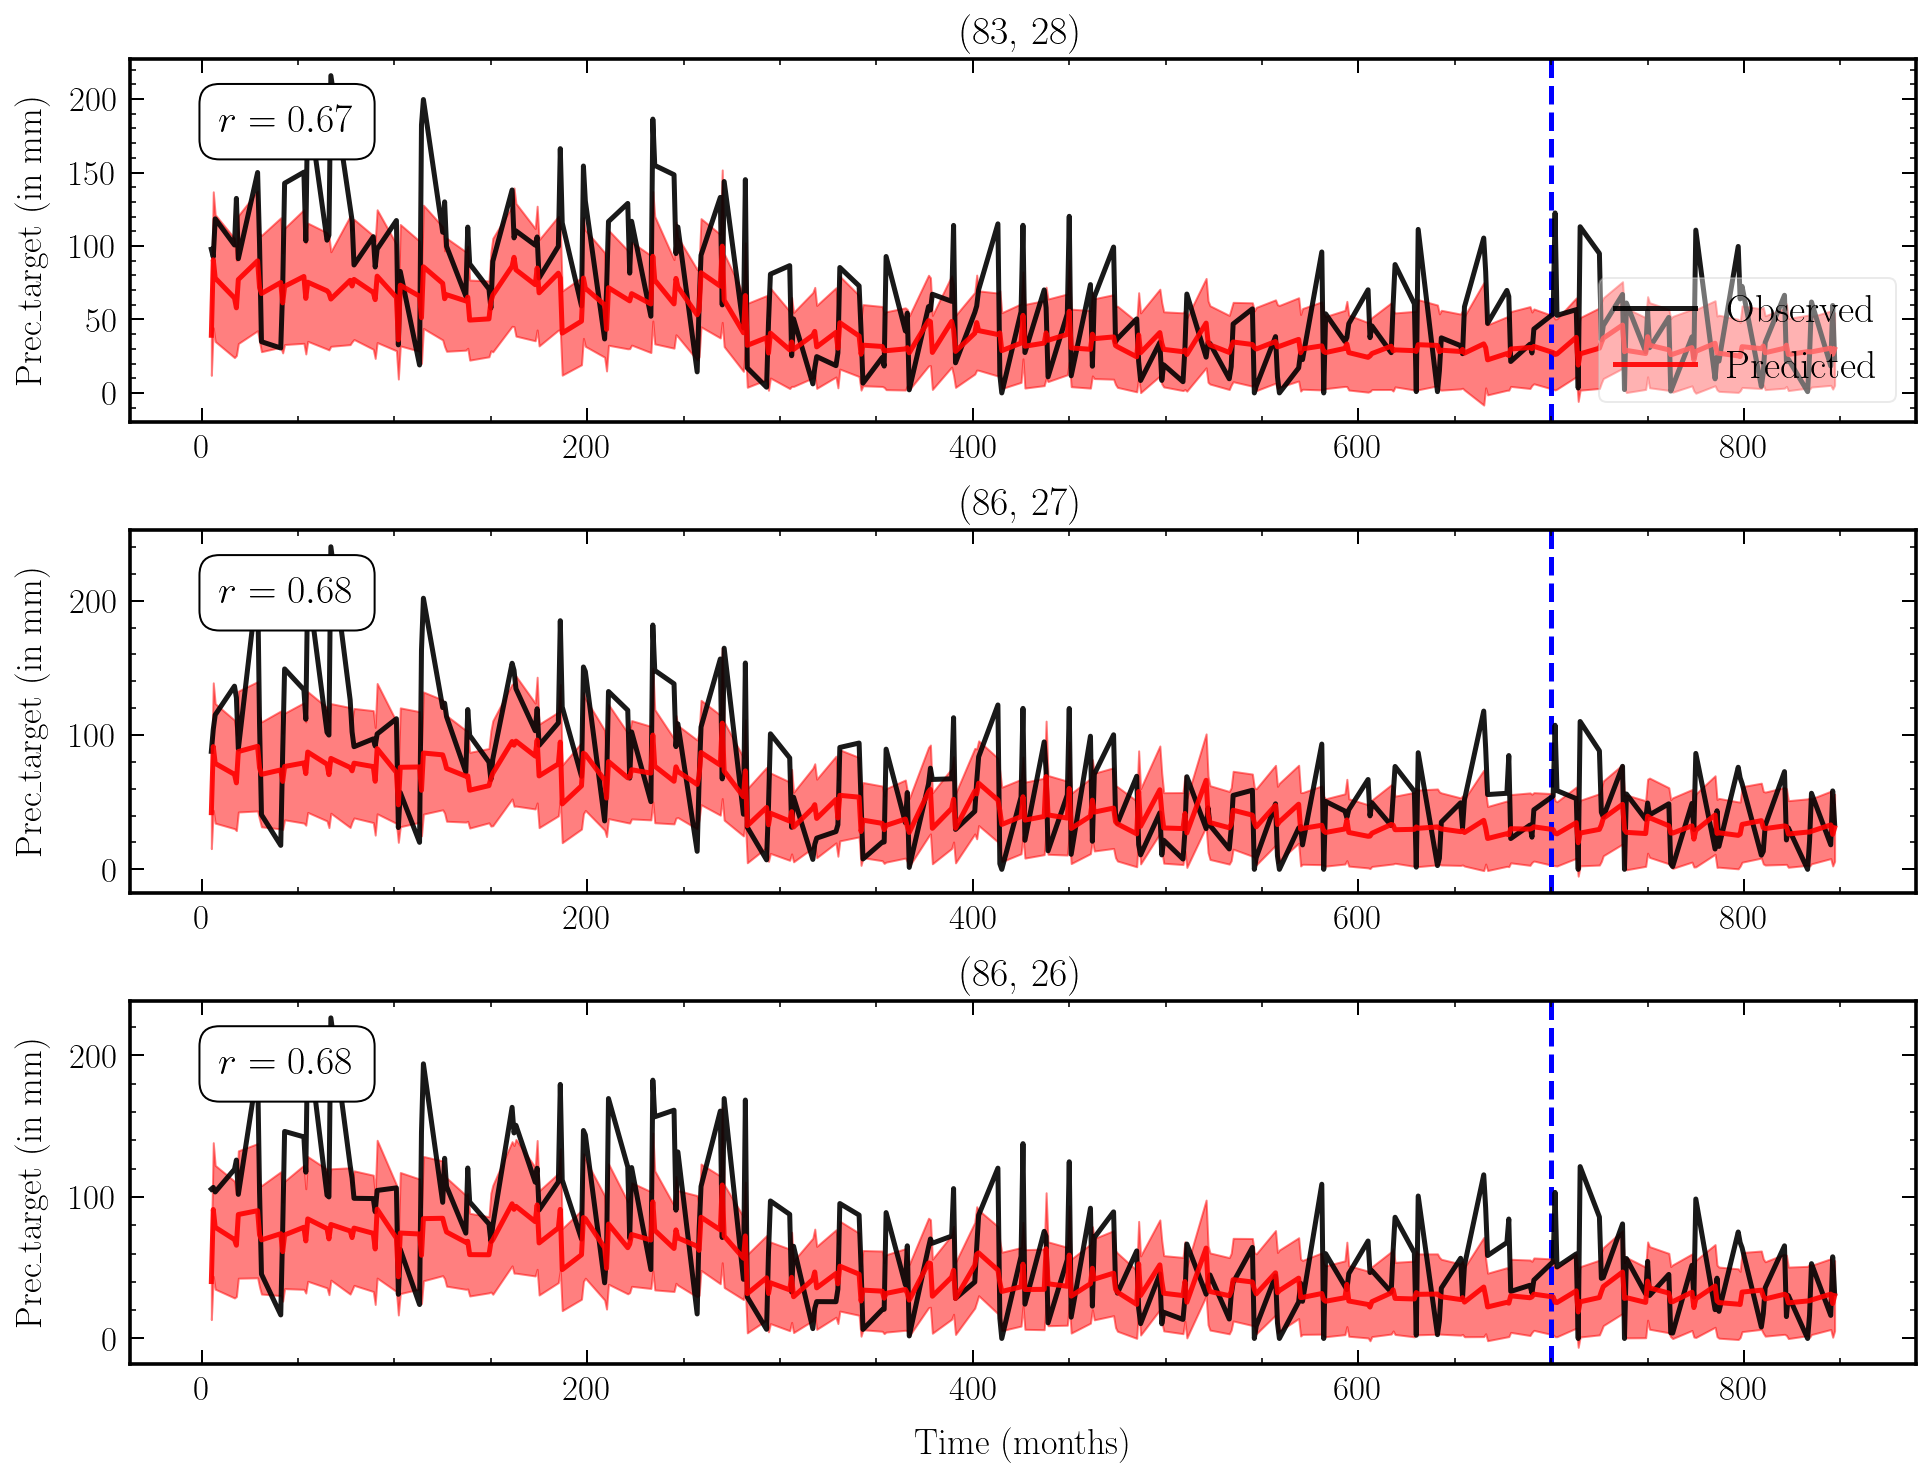

In [16]:
fig, ax= plt.subplots(3, 1, figsize=(16, 12))
config= 'best'

if config == 'best':
    ind_y_arr= grid_all[0][best_ind_arr]
    ind_x_arr= grid_all[1][best_ind_arr]
elif config == 'worst':
    ind_y_arr= grid_all[0][worst_ind_arr]
    ind_x_arr= grid_all[1][worst_ind_arr]
elif config == 'random':
    ind_y_arr= grid_all[0][rand_ind_arr]
    ind_x_arr= grid_all[1][rand_ind_arr]

for i in range(3):
    pearson_r= stats.pearsonr(Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]], Y_obs_xr[:, ind_y_arr[i], ind_x_arr[i]])[0]
    Y_pred_low_1sig= Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]] - Y_dist_scale_xr[:, ind_y_arr[i], ind_x_arr[i]]
    Y_pred_high_1sig= Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]] + Y_dist_scale_xr[:, ind_y_arr[i], ind_x_arr[i]]

    ax[i].plot(Y_obs_xr.time, Y_obs_xr[:, ind_y_arr[i], ind_x_arr[i]], color= 'black', label= 'Observed')
    ax[i].plot(Y_obs_xr.time, Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]], color= 'red', label= 'Predicted')
    ax[i].fill_between(Y_obs_xr.time, Y_pred_low_1sig, Y_pred_high_1sig, color= 'red', alpha= 0.5)

    if i== 2:
        ax[i].set_xlabel(r'Time (months)', fontsize= 18);
    ax[i].set_ylabel(pred_var + '_target ' + '(in %s)'%(unit_arr[pred_var]), fontsize= 18);
    ax[i].text(0.05, 0.8, r'$r = %.2f$'%pearson_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    #ax[i].set_ylim(10, 40);
    if i== 0:
        ax[i].legend(loc='lower right', frameon= True, fontsize= 20);
    ax[i].set_title(r'(%d, '%ind_x_arr[i] + '%d)'%ind_y_arr[i], fontsize= 20);
    fig.subplots_adjust(hspace= 0.3)
    ax[i].axvline(x= 700, color= 'blue', lw= 2.5, linestyle= '--', zorder= 1)
    plt.savefig('../plots/%s'%pred_var + '_ngboost_%s'%config + '_prediction_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

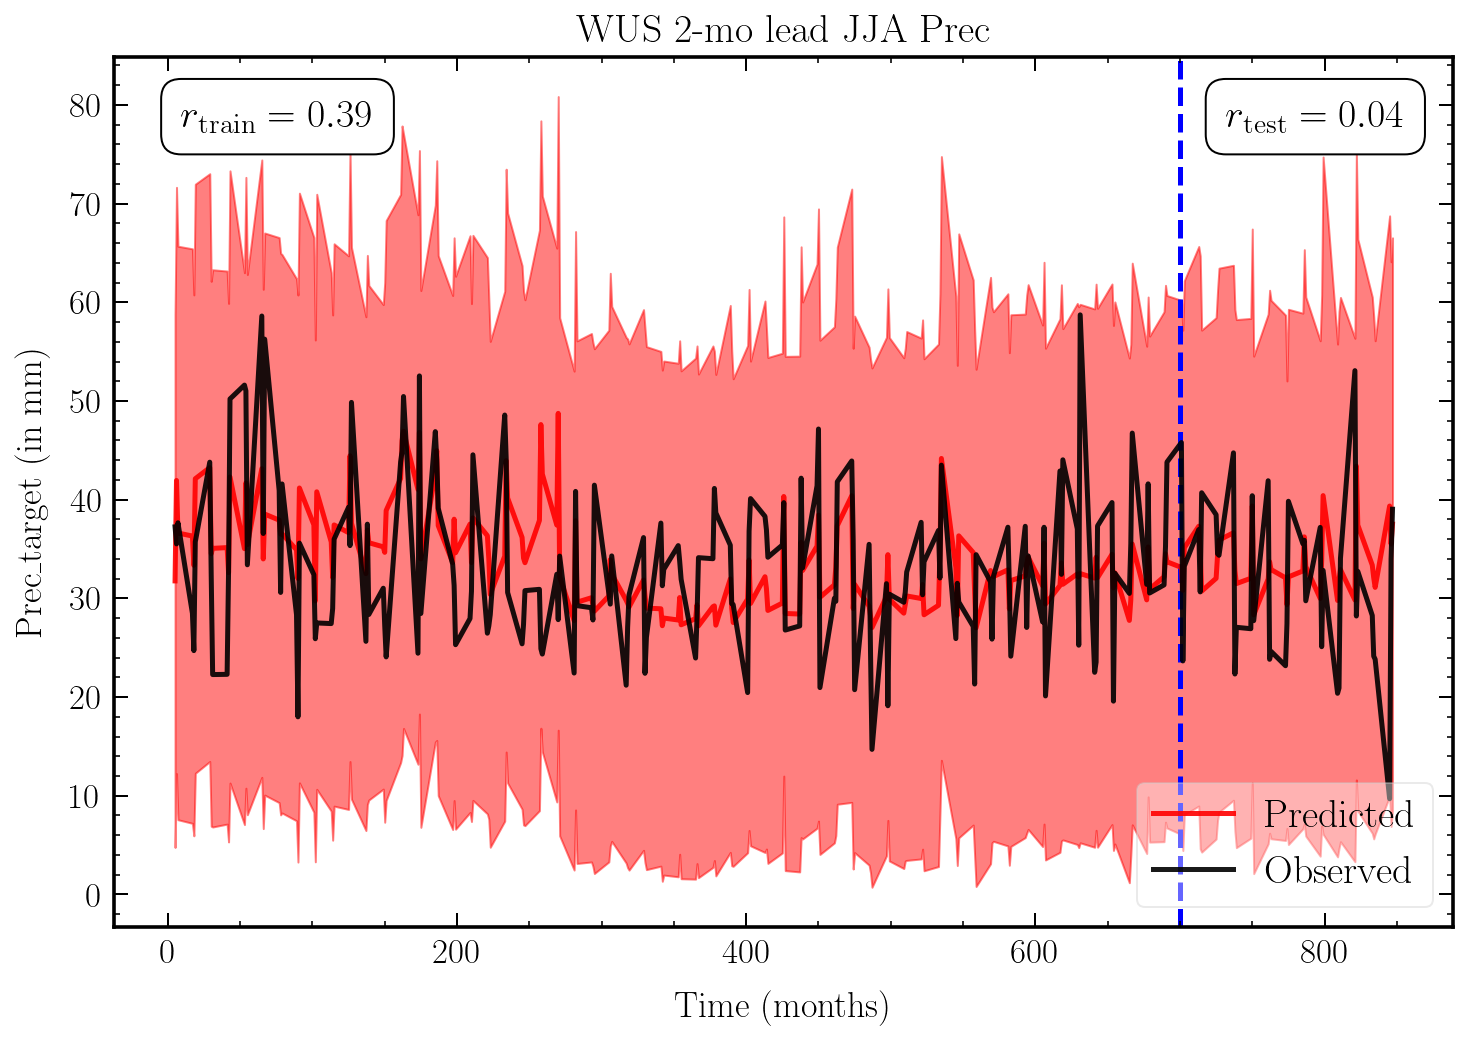

In [17]:
fig, ax= plt.subplots(1, 1, figsize=(12, 8))

plt.plot(Y_dist_loc_xr.time, np.mean(Y_dist_loc_xr, axis= (1,2)), color= 'red', label= 'Predicted')
plt.fill_between(Y_dist_loc_xr.time, np.mean(Y_dist_loc_xr, axis= (1,2)) - np.mean(Y_dist_scale_xr, axis= (1,2)), \
                                                np.mean(Y_dist_loc_xr, axis= (1,2)) + np.mean(Y_dist_scale_xr, axis= (1,2)), color= 'red', alpha= 0.5)
plt.plot(Y_dist_loc_xr.time, np.mean(Y_obs_xr, axis= (1,2)), color= 'black', label= 'Observed')

pearson_train_r= stats.pearsonr(np.mean(Y_dist_loc_xr[:175, :, :], axis= (1,2)), np.mean(Y_obs_xr[:175, :, :], axis= (1,2)))[0]
pearson_test_r= stats.pearsonr(np.mean(Y_dist_loc_xr[175:, :, :], axis= (1,2)), np.mean(Y_obs_xr[175:, :, :], axis= (1,2)))[0]

ax.set_xlabel(r'Time (months)', fontsize= 18);
ax.set_ylabel(pred_var + '_target ' + '(in %s)'%(unit_arr[pred_var]), fontsize= 18);
ax.text(0.05, 0.92, r'$r_{\rm train} = %.2f$'%pearson_train_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
        transform=ax.transAxes)
ax.text(0.83, 0.92, r'$r_{\rm test} = %.2f$'%pearson_test_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
        transform=ax.transAxes)
ax.legend(loc='lower right', frameon= True, fontsize= 20);
ax.set_title(r'WUS 2-mo lead JJA %s'%pred_var, fontsize= 20);
ax.axvline(x= 700, color= 'blue', lw= 2.5, linestyle= '--', zorder= 1)
plt.savefig('../plots/%s'%pred_var + '_ngboost_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

In [18]:
lat_long_fire_grid= coord_transform(Y_dist_loc_xr['X'][:].data, Y_dist_loc_xr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

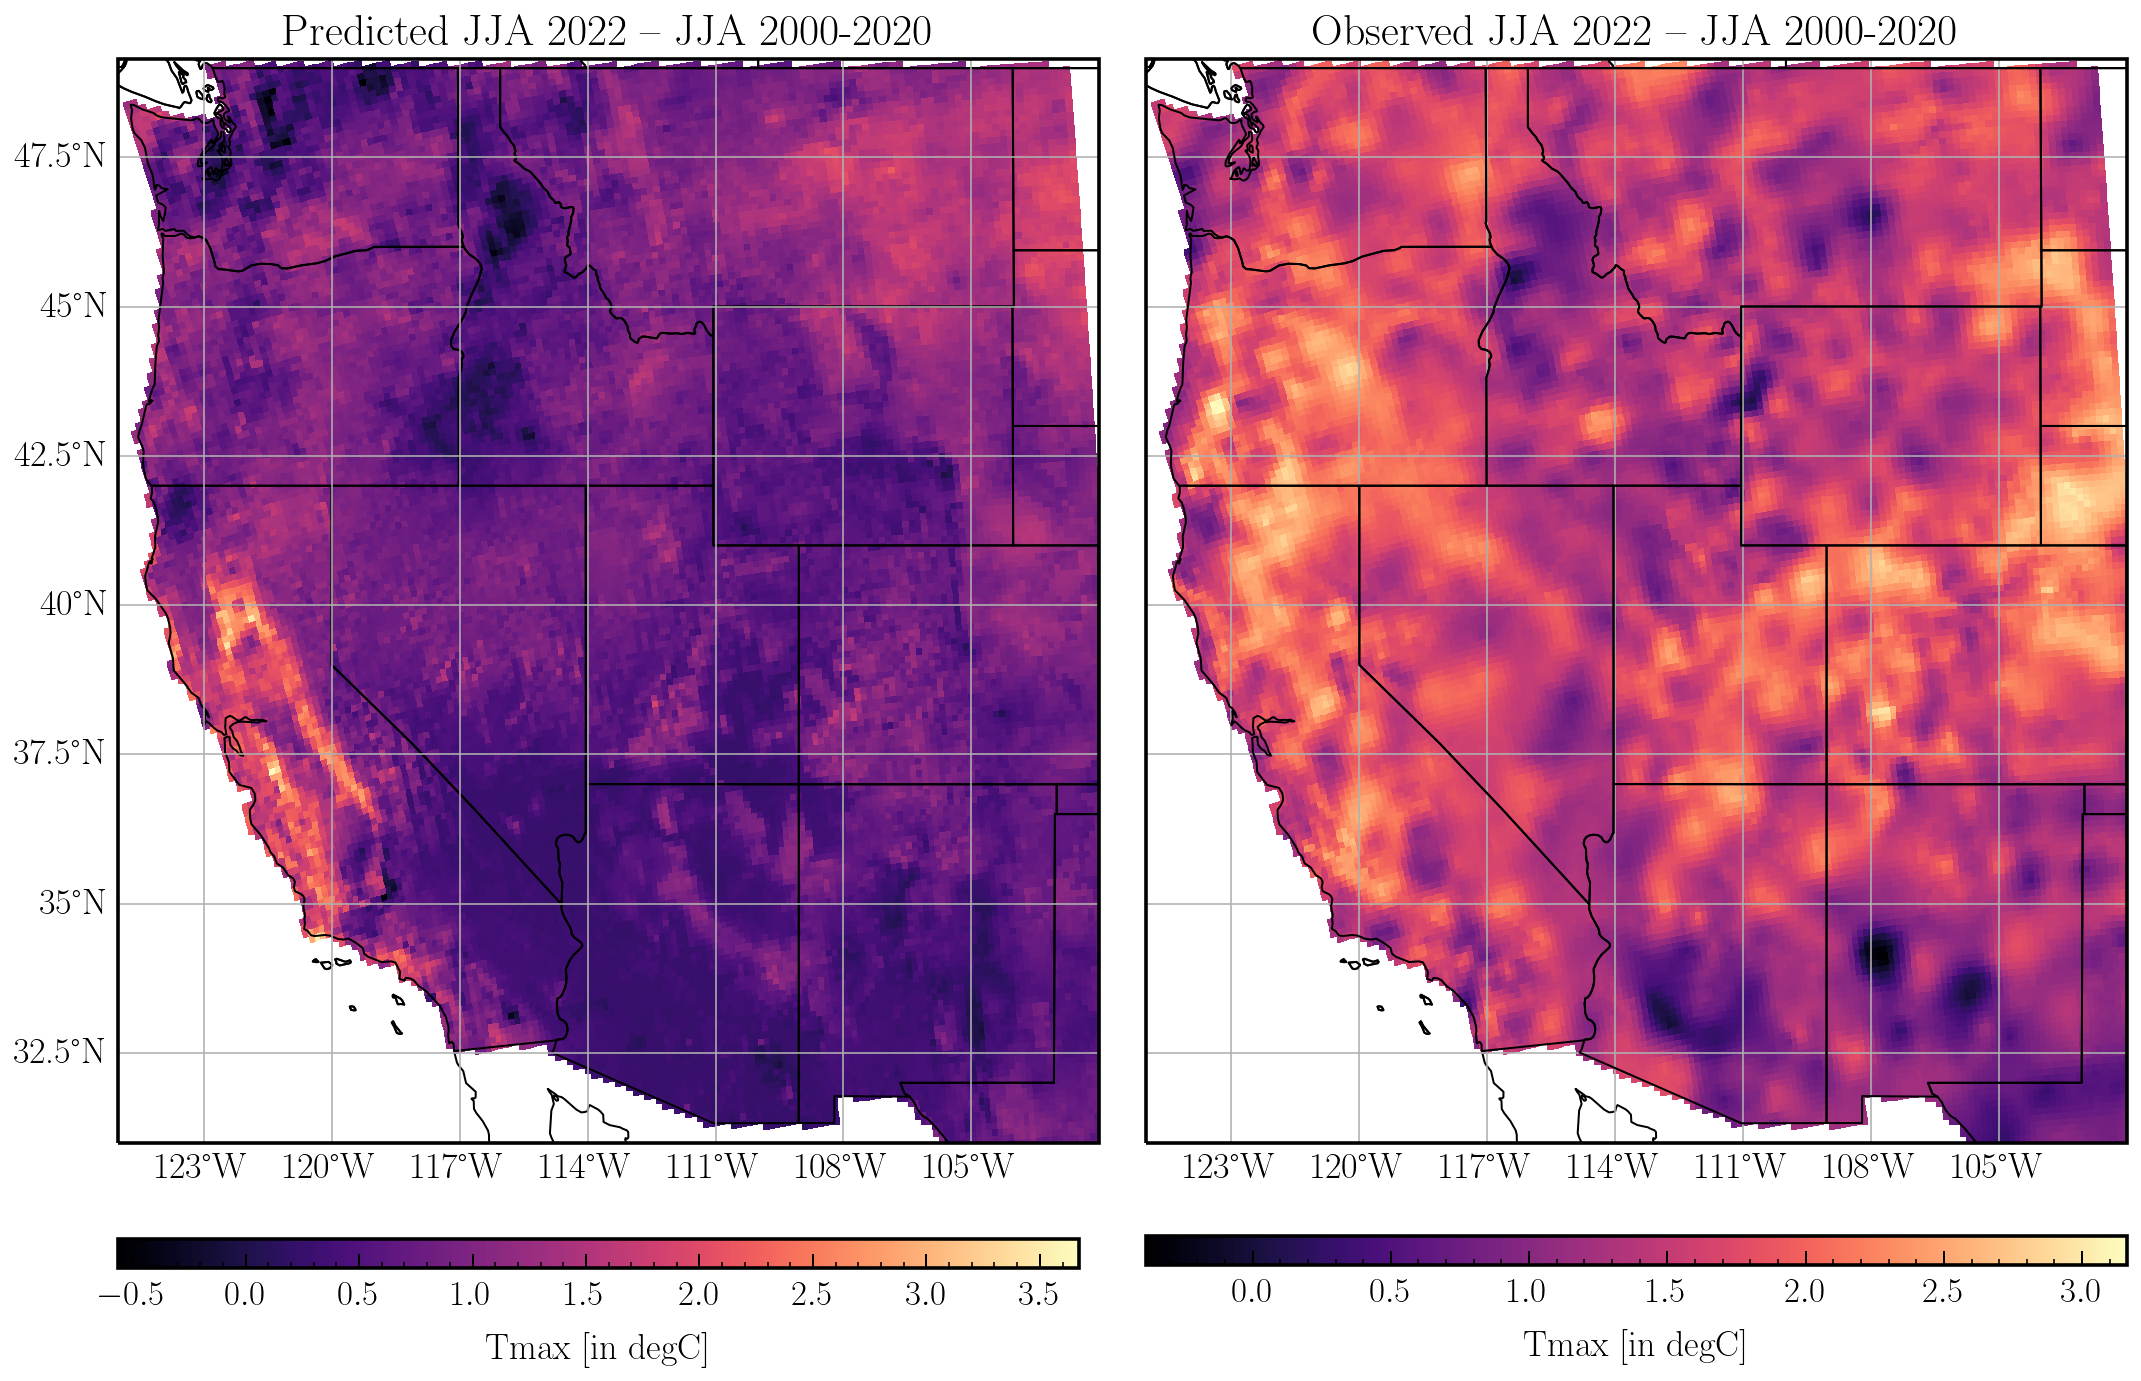

In [19]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_dist_loc_xr[-3:, :, :], axis= 0) - np.mean(Y_dist_loc_xr[147:207, :, :], axis= 0), cmap=plt.cm.magma) 
cax= fig.add_axes([ax.get_position().x0,ax.get_position().y0 - 0.2, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
cbar.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'Predicted JJA 2022 -- JJA 2000-2020', fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS0= ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_obs_xr[-3:, :, :], axis= 0) - np.mean(Y_obs_xr[147:207, :, :], axis= 0), cmap=plt.cm.magma) 
cax0= fig.add_axes([ax0.get_position().x0,ax0.get_position().y0 - 0.085, ax0.get_position().width, 0.02])
cbar0= fig.colorbar(CS0, cax= cax0, orientation= 'horizontal', shrink= 0.7)
cbar0.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)
ax0.set_title(r'Observed JJA 2022 -- JJA 2000-2020', fontsize= 22);
#plt.savefig('../plots/%s'%pred_var + '_spatial_trends_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 200);

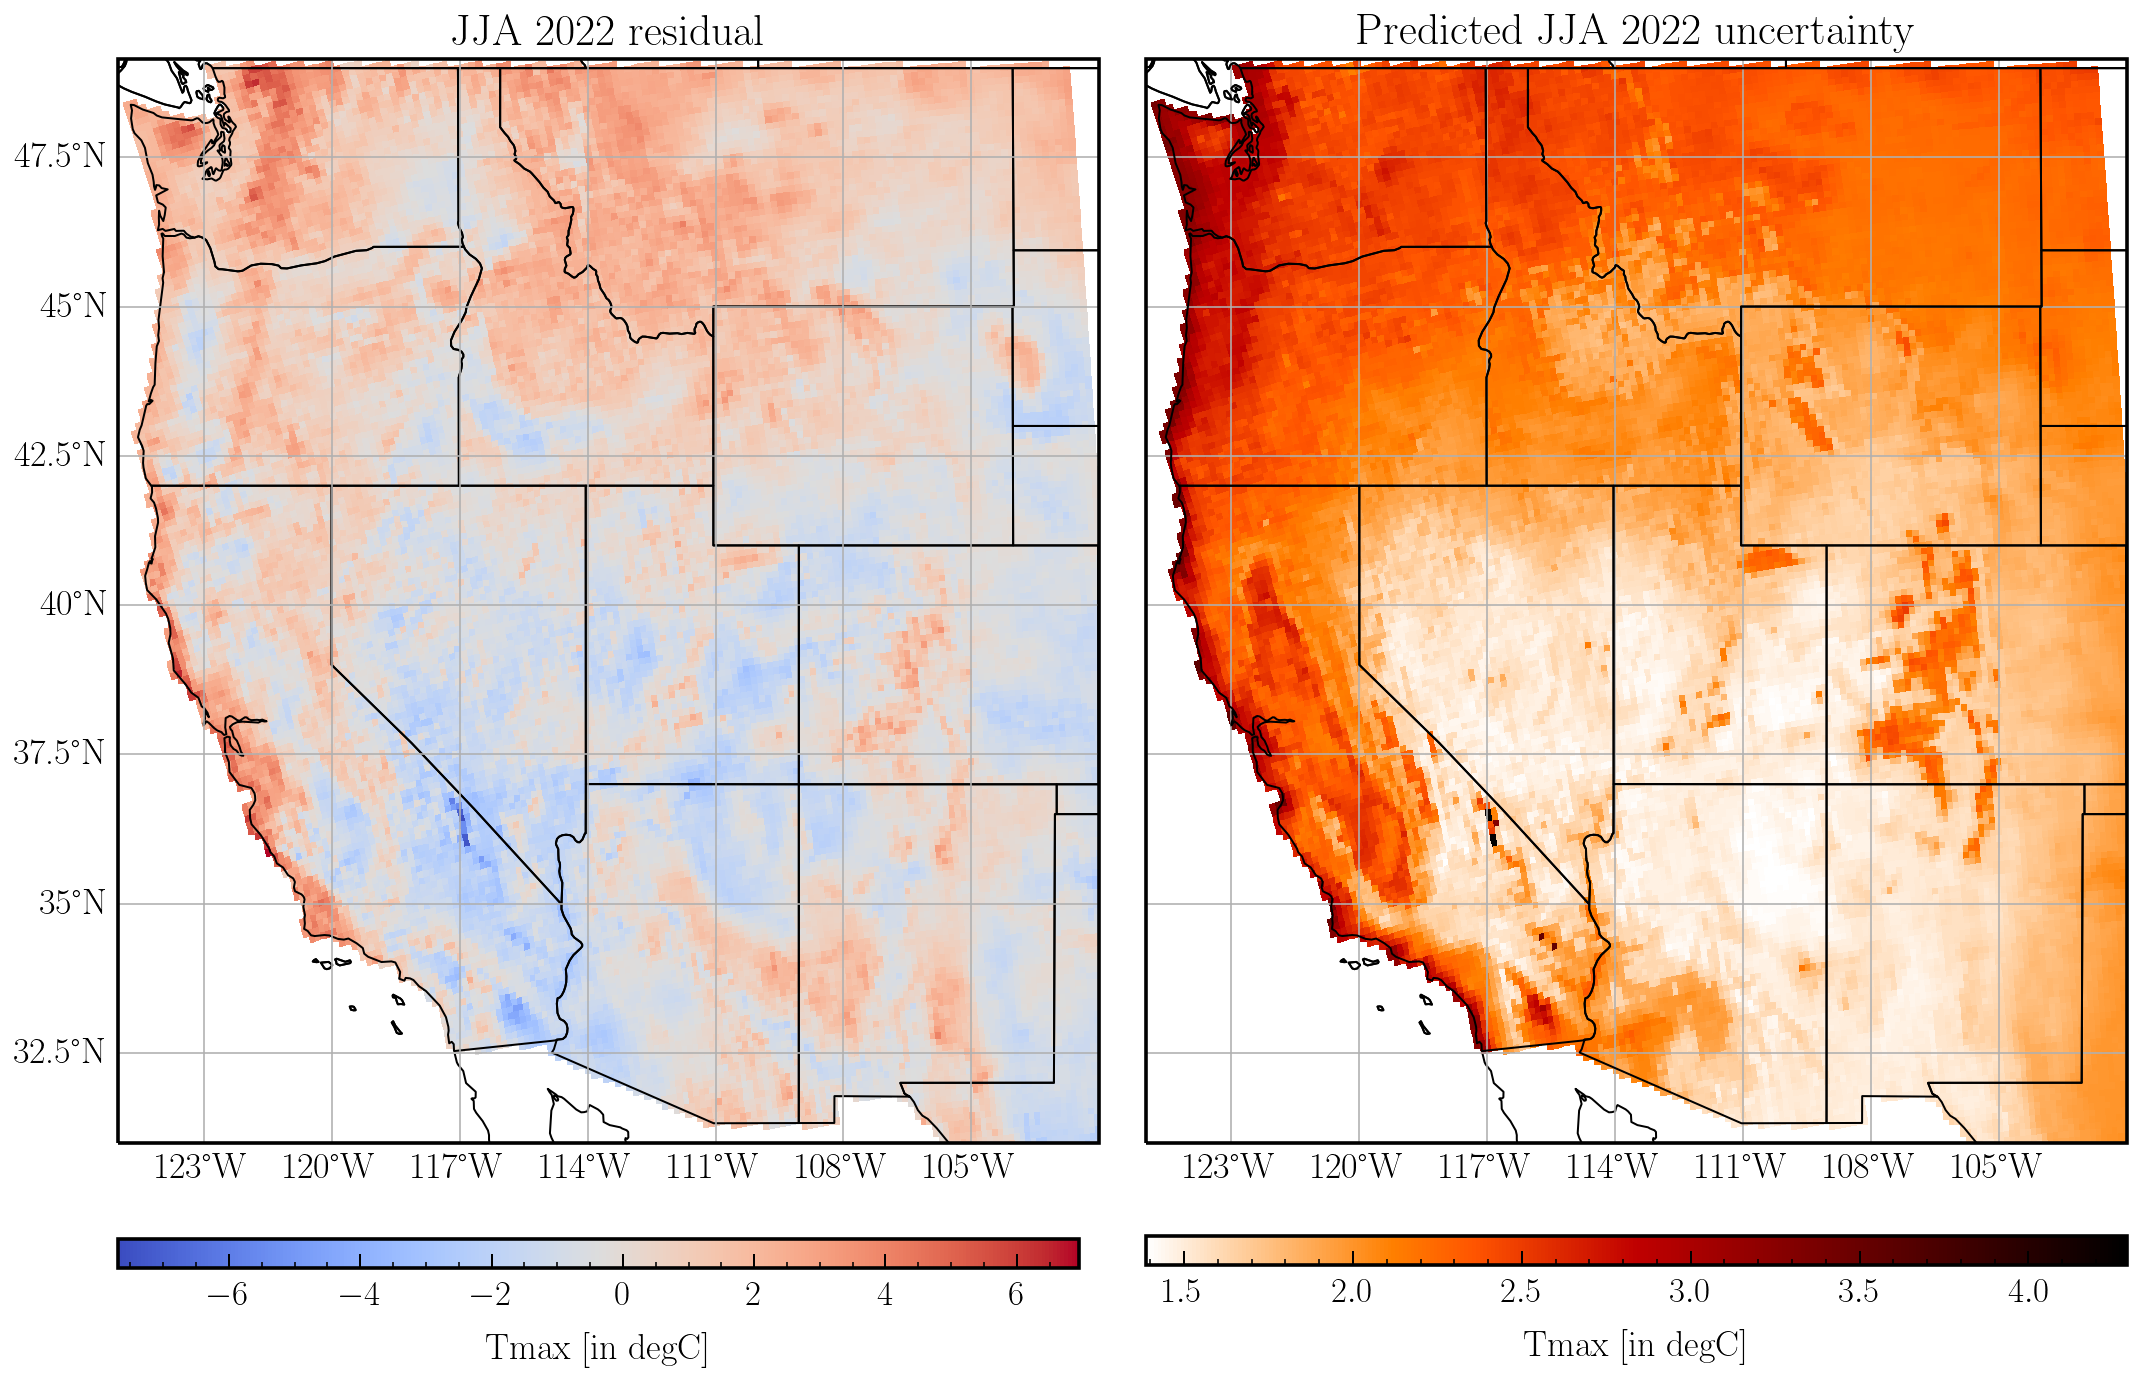

In [20]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_dist_loc_xr[-3:, :, :], axis= 0) - np.mean(Y_obs_xr[-3:, :, :], axis= 0), cmap=plt.cm.coolwarm) # normalized fire probability summed over all months
cax= fig.add_axes([ax.get_position().x0,ax.get_position().y0 - 0.2, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
cbar.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'JJA 2022 residual', fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS0= ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_dist_scale_xr[-3:, :, :], axis= 0) , cmap=plt.cm.gist_heat_r) # normalized fire probability summed over all months
cax0= fig.add_axes([ax0.get_position().x0,ax0.get_position().y0 - 0.085, ax0.get_position().width, 0.02])
cbar0= fig.colorbar(CS0, cax= cax0, orientation= 'horizontal', shrink= 0.7)
cbar0.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)
ax0.set_title(r'Predicted JJA 2022 uncertainty', fontsize= 22);
#plt.savefig('../plots/%s'%pred_var + '_spatial_residual_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 200);

In [ ]:
# Load all predicted variables and save them as dataframes